In [1]:
import math

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn


class MLP(nn.Module):
    def __init__(self, input_channel: int, dims: list[int], activation = nn.ReLU, bias=True, last_layer_act=False):
        super().__init__()

        all_dims = [input_channel, *dims]
        layers = []
        for i, (in_c, out_c) in enumerate(zip(all_dims, all_dims[1:])):
            layers.append(nn.Sequential(
                nn.Linear(in_c, out_c, bias=bias),
                nn.Identity() if i == len(all_dims) - 2 and not last_layer_act else activation()
            ))
        self.net = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.net:
            x = layer(x)
        return x

def get_target(x):
    with torch.no_grad():
        return (x ** 3).float()

def weights_init(m: nn.Module, value=1):
    torch.manual_seed(0)
    for param in m.parameters():
        nn.init.uniform_(param, -value, value)

def eval_func(func, name: str, precision = 100, cols=4, red=None, plot_fn=None, show_weigths=True):
    if isinstance(precision, int):
        x = torch.linspace(-1, 1, precision)
    else:
        x = torch.as_tensor(precision)
    x = x.reshape(-1, 1)
    y = func(x).detach().cpu()
    if y.shape != x.shape:
        y = torch.as_tensor([red(yy) for yy in y])
    else:
        y = y.squeeze(-1)
    x = x.squeeze(-1)

    if plot_fn:
        plot_fn(x, y, func, name)
    else:
        sns.scatterplot(x=x, y=y, label=name)
        plt.xlabel("x")
        plt.ylabel("y")

    if isinstance(func, nn.Module) and show_weigths:
        params = list(func.named_parameters())
        rows = math.ceil(len(params) / cols)
        fig, axs = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows), sharex=True, sharey=True)
        axs = axs.flatten()
        for ax, (name, param) in zip(axs, params):
            sns.kdeplot(param.detach().cpu(), label=name, ax=ax, common_norm=False, warn_singular=False)
            ax.set_title(f"{name} {tuple(param.shape)}")
            ax.x_label = None
            legend = ax.get_legend()
            if legend:
                legend.remove()

def default_sampler(b):
    return torch.randn(b, 1)

def run(model, epochs, batch_size, lr, loss_print_ratio = 0.1, device="cpu", sampler=default_sampler, precision=100, target_fn=get_target, red = None, val_precision=100, show_weigths=True, init_weights=True, callback=None):
    if init_weights:
        weights_init(model)
    model = model.to(device)
    print_every = math.ceil(epochs * loss_print_ratio)
    for e in range(epochs):
        x = sampler(batch_size).to(device=device)
        y = target_fn(x)

        y_pred = model(x)
        if y_pred.shape != y.shape:
            y_pred = torch.stack([red(yy) for yy in y_pred]).unsqueeze(dim=-1)

        loss = nn.MSELoss()(y_pred, y)
        if e % print_every == 0:
            print("Epoch: {} ; Loss {:.4f}".format(e, loss.item() / batch_size))
        loss.backward()

        if callback:
            callback(epoch=e, loss=loss, x=x, y=y, pred=y_pred)

        with torch.no_grad():
            for param in model.parameters():
                param -= lr * param.grad
                param.grad.zero_()

    eval_func(target_fn, "Target", precision=precision, red=red)
    eval_func(model.cpu(), "Pred", precision=val_precision if val_precision is not None else precision, red=red, show_weigths=show_weigths)

Epoch: 0 ; Loss 0.0625
Epoch: 2 ; Loss 0.3616
Epoch: 4 ; Loss 0.2468
Epoch: 6 ; Loss 0.0819
Epoch: 8 ; Loss 0.9108
Epoch: 10 ; Loss 0.2095
Epoch: 12 ; Loss 0.2283
Epoch: 14 ; Loss 1.2104
Epoch: 16 ; Loss 0.4501
Epoch: 18 ; Loss 0.2958


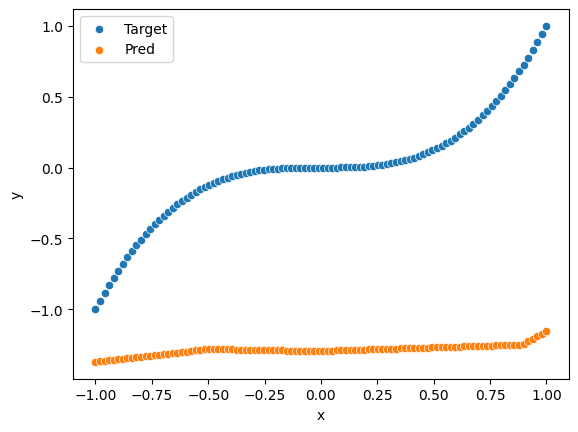

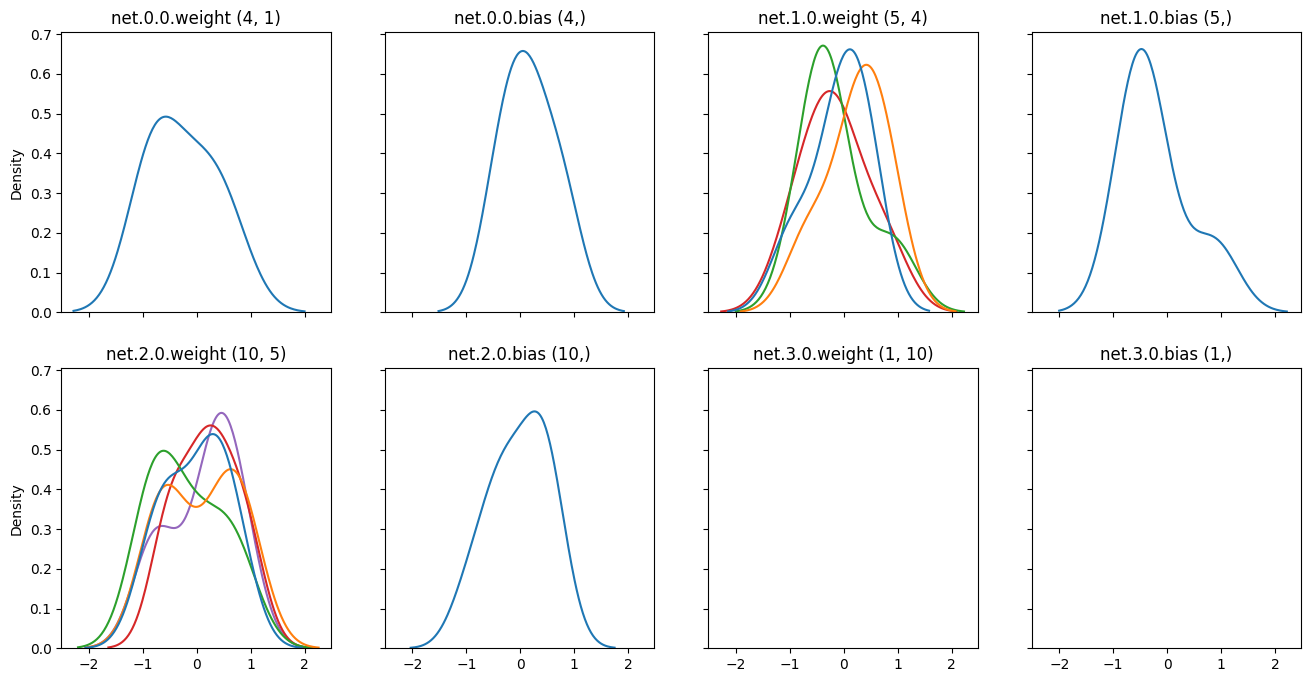

In [2]:
m1 = MLP(1, [4, 5, 10, 1])
run(m1, 20, 32, 1e-5)

Epoch: 0 ; Loss 1.6958
Epoch: 1000 ; Loss 0.3242
Epoch: 2000 ; Loss 0.0175
Epoch: 3000 ; Loss 4.5659
Epoch: 4000 ; Loss 0.0098
Epoch: 5000 ; Loss 0.0065
Epoch: 6000 ; Loss 0.0240
Epoch: 7000 ; Loss 0.0023
Epoch: 8000 ; Loss 0.0013
Epoch: 9000 ; Loss 0.0010


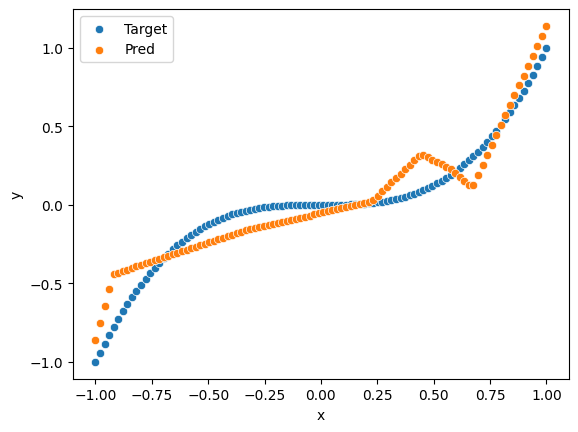

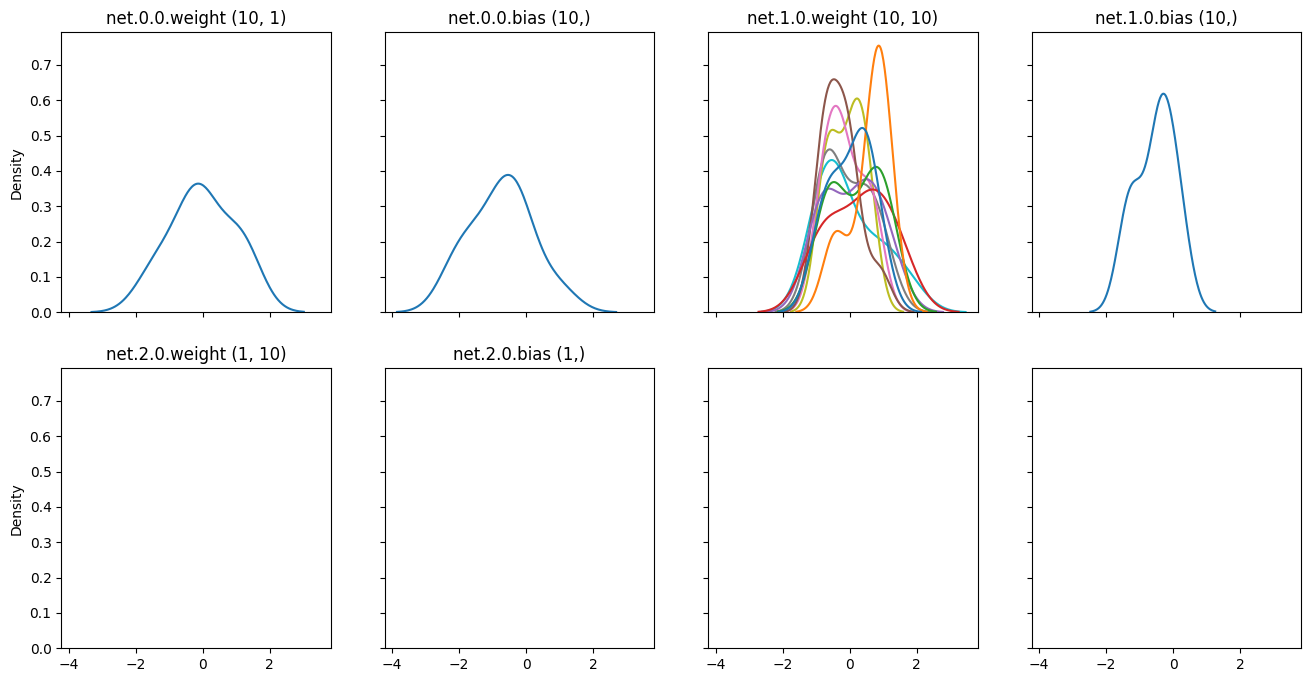

In [3]:
m2 = MLP(1, [10] * 2 + [1], nn.ReLU, bias=True)
run(m2, 10_000, 8, 1e-3)

Epoch: 0 ; Loss 0.1095
Epoch: 500 ; Loss 1.0924
Epoch: 1000 ; Loss 0.1743
Epoch: 1500 ; Loss 3.5614
Epoch: 2000 ; Loss 1.7633
Epoch: 2500 ; Loss 0.8825
Epoch: 3000 ; Loss 0.0206
Epoch: 3500 ; Loss 2.8097
Epoch: 4000 ; Loss 0.6756
Epoch: 4500 ; Loss 1.6758


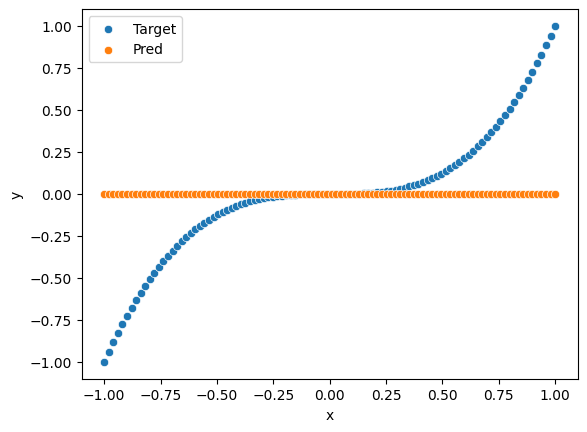

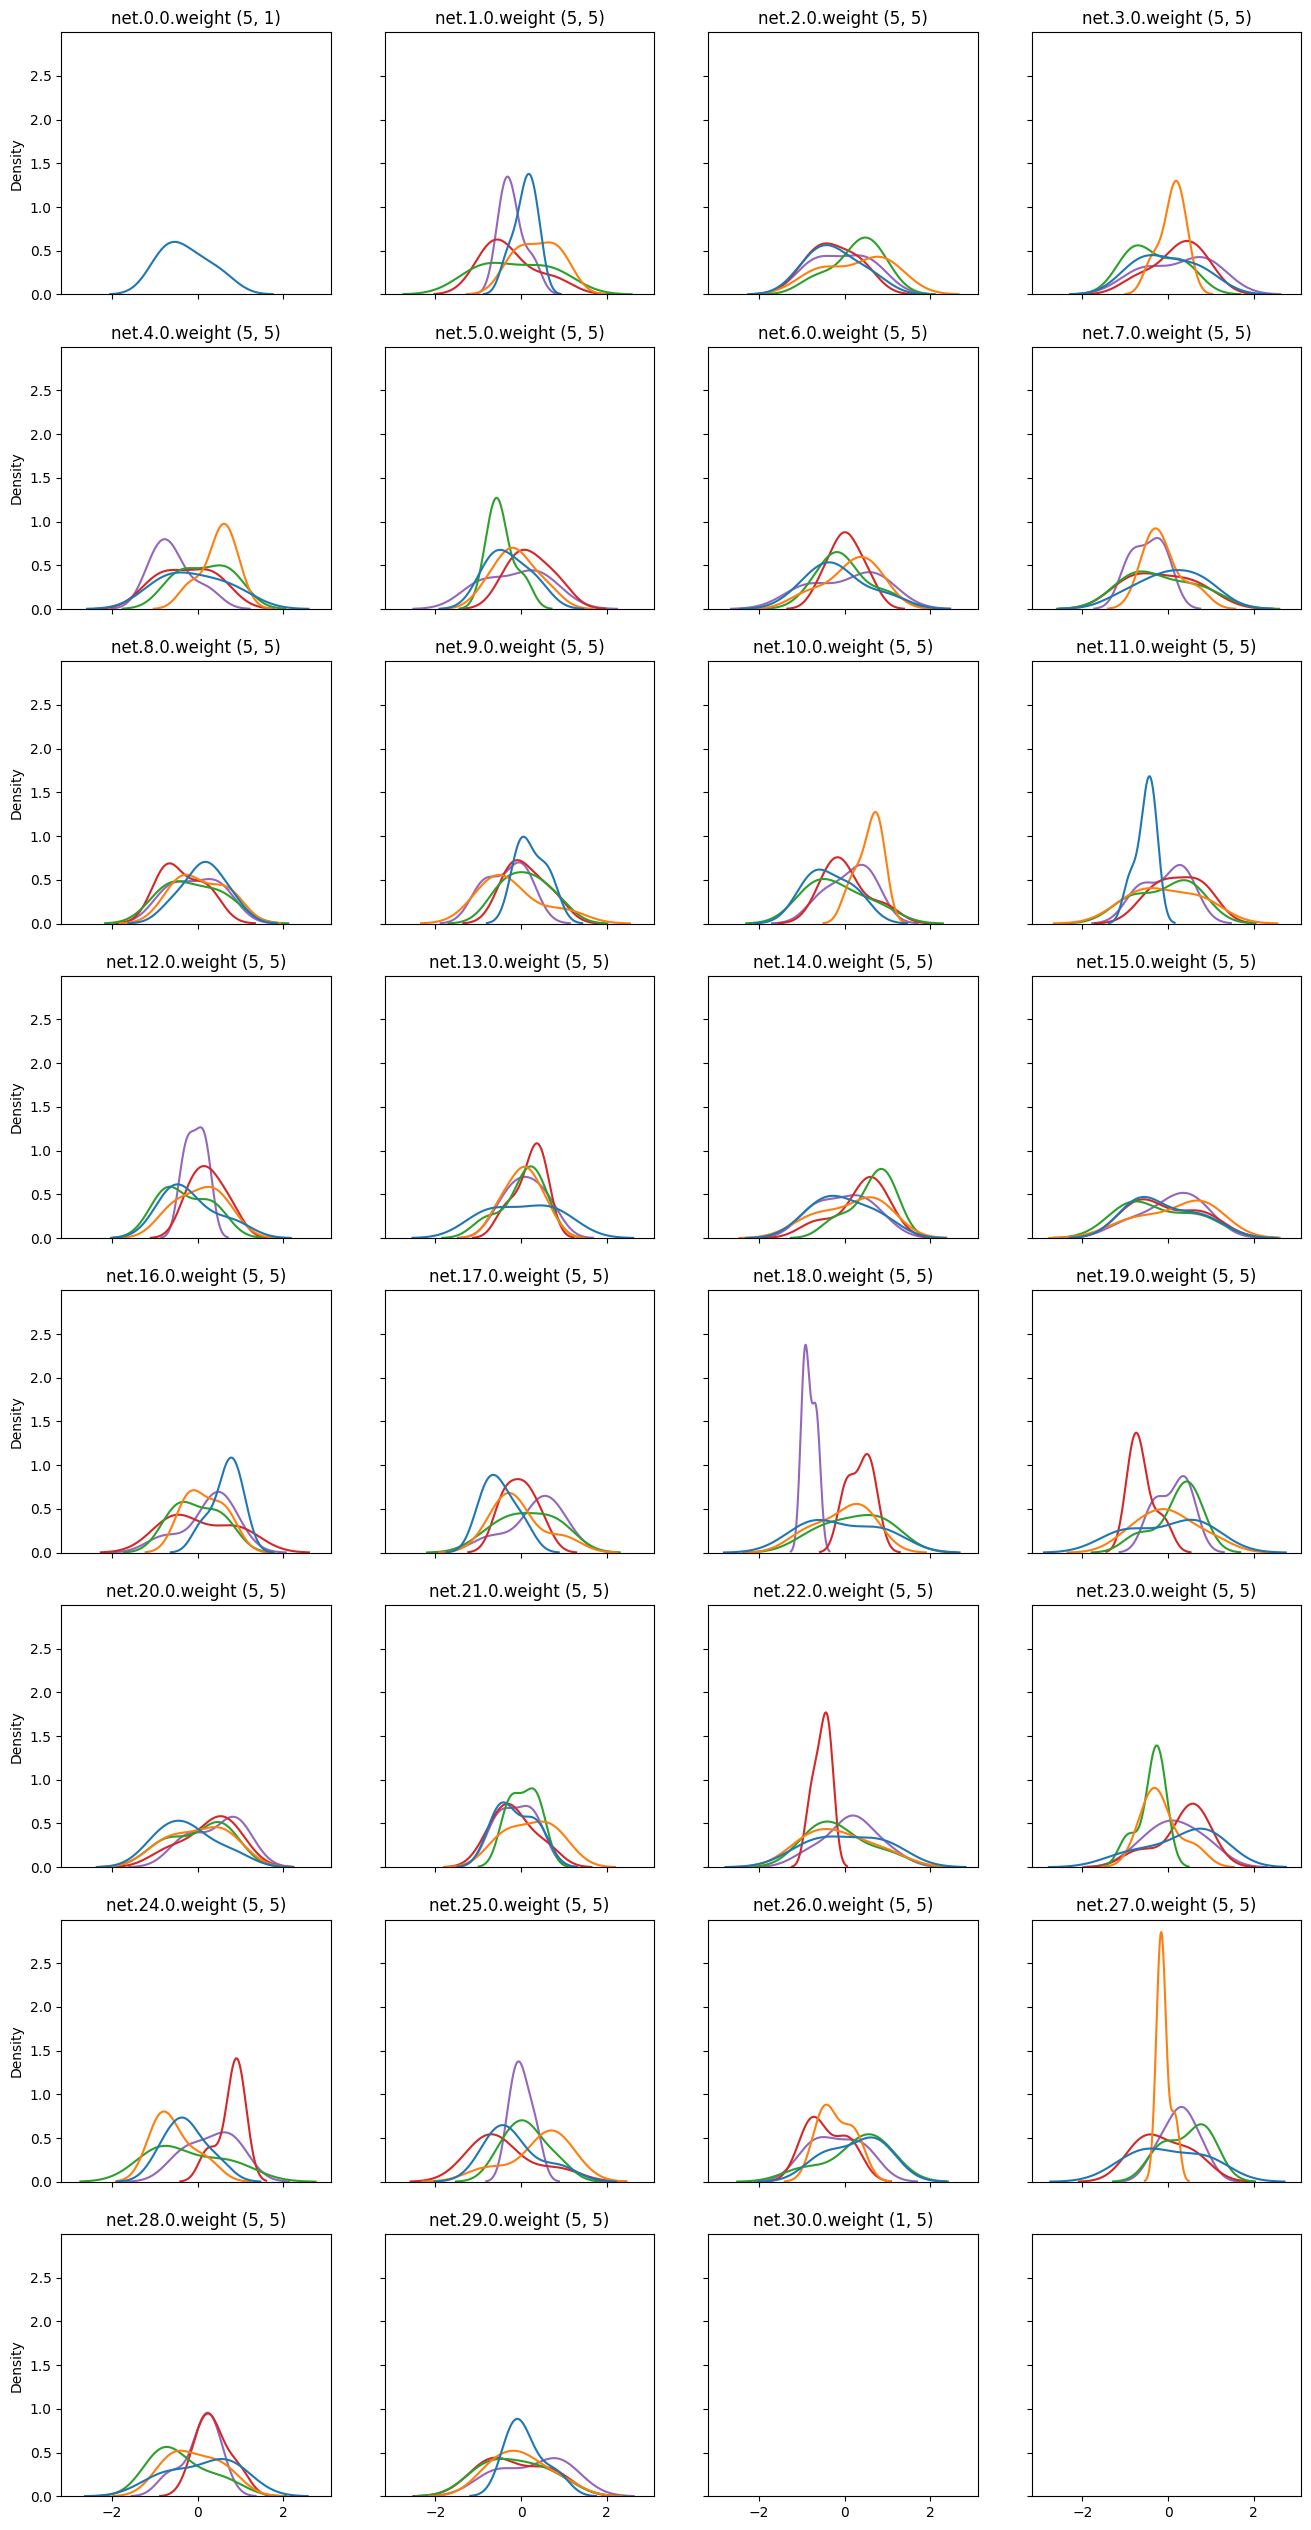

In [4]:
m3 = MLP(1, [5] * 30 + [1], nn.ReLU, bias=False)
run(m3, 5000, 8, 1e-3)

Epoch: 0 ; Loss 0.1342
Epoch: 100 ; Loss 0.0940
Epoch: 200 ; Loss 0.0640
Epoch: 300 ; Loss 0.1591
Epoch: 400 ; Loss 0.0920
Epoch: 500 ; Loss 0.1116
Epoch: 600 ; Loss 0.1018
Epoch: 700 ; Loss 0.1109
Epoch: 800 ; Loss 0.1272
Epoch: 900 ; Loss 0.1385

net.0.0.weight Parameter containing:
tensor([[-0.0075],
        [ 2.1932]], requires_grad=True)

net.0.0.bias Parameter containing:
tensor([-0.8230, -0.7220], requires_grad=True)


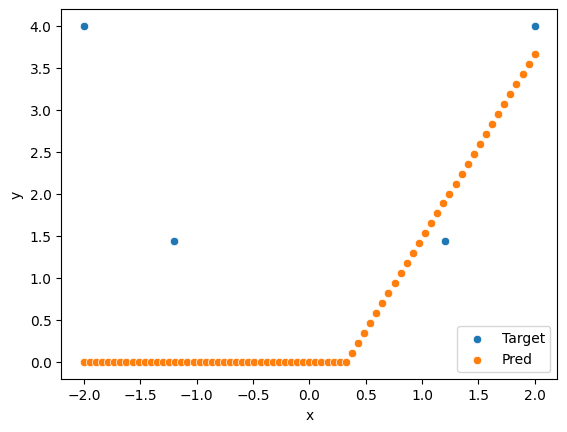

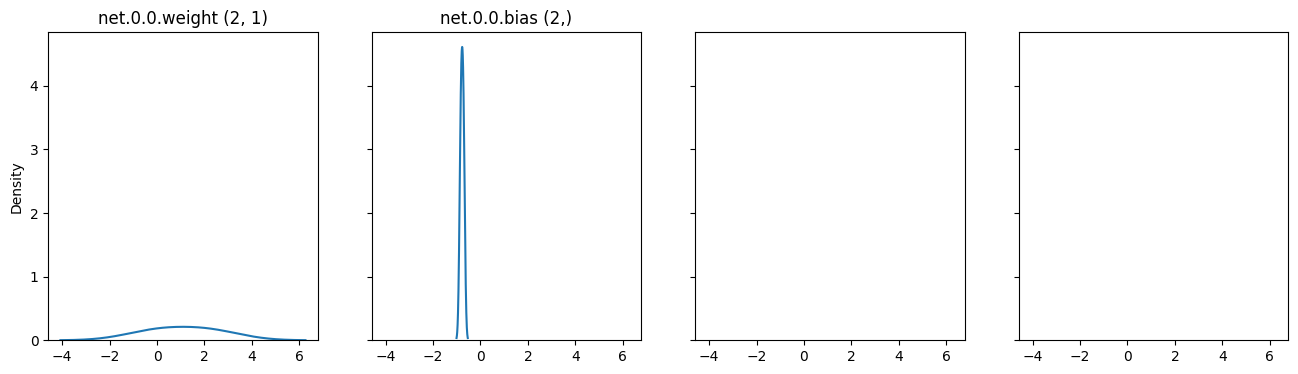

In [28]:
import pandas as pd


class Sampler():
    def __init__(self, vals: list):
        self.vals = vals

    def __call__(self, b):
        idx = torch.randint(0, len(self.vals), (b,))
        return torch.tensor([self.vals[i] for i in idx]).unsqueeze(-1)

ds = [-2.0, 0.0, 2.0, 1.2, -1.2]
sampler = Sampler(ds)
m4 = MLP(1, [2], activation=nn.ReLU, last_layer_act=True)

df_c = pd.DataFrame({kk: [] for k, v in m4.named_parameters() for kk in [k, f"{k}.grad"]}, dtype=object)


def callback(epoch, **kwargs):
    num = len(df_c)
    for n, p in m4.named_parameters():
        df_c.loc[num, n] = p.detach().cpu().tolist()
        df_c.loc[num, f"{n}.grad"] = p.grad.detach().cpu().tolist()

run(m4, 10000, 32, 1e-2, sampler=sampler, precision=ds, target_fn=lambda x: x**2, red=torch.sum, val_precision=torch.linspace(-2, 2, 75), init_weights=True, callback=callback)
for n, p in m4.named_parameters():
    print(f"\n{n}", p)

,w1,w2,b1,b2,w1_grad,w2_grad,b1_grad,b2_grad
count,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
mean,2.854159e+06,6.939815e+06,-6.025362e+06,-1.157595e+07,-2.739500e+05,-6.053233e+05,6.105018e+05,1.210650e+06
std,9.128486e+05,2.797367e+06,5.804490e+05,1.674215e+06,4.295851e+07,8.724069e+07,4.210716e+06,4.639519e+06
min,-4.866621e+04,-1.994482e+05,-6.105018e+06,-1.210648e+07,-1.337378e+09,-2.744795e+09,-2.070902e+04,-1.373644e+00
25%,2.739501e+06,6.053305e+06,-6.105018e+06,-1.210648e+07,0.000000e+00,7.871875e+01,0.000000e+00,3.978125e+01
50%,2.739501e+06,6.056596e+06,-6.105018e+06,-1.210474e+07,0.000000e+00,4.609438e+03,0.000000e+00,2.348594e+03
75%,2.739501e+06,6.241909e+06,-6.105018e+06,-1.200588e+07,0.000000e+00,2.972359e+05,0.000000e+00,1.503386e+05
max,1.332512e+07,2.724850e+07,2.062672e+02,-7.109702e-01,8.983303e+07,8.983303e+07,5.277230e+07,5.277230e+07


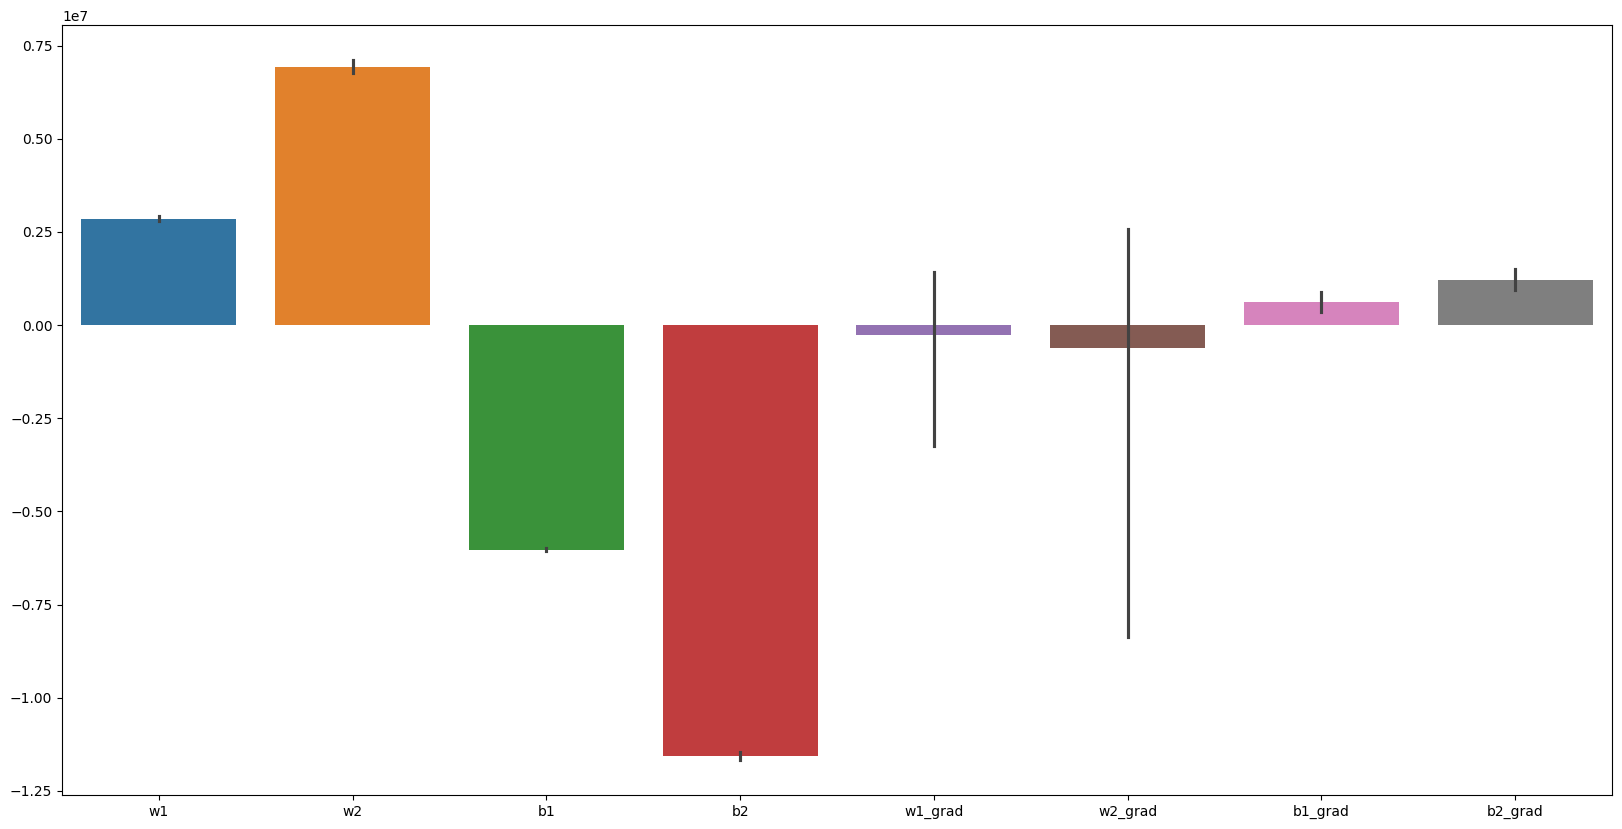

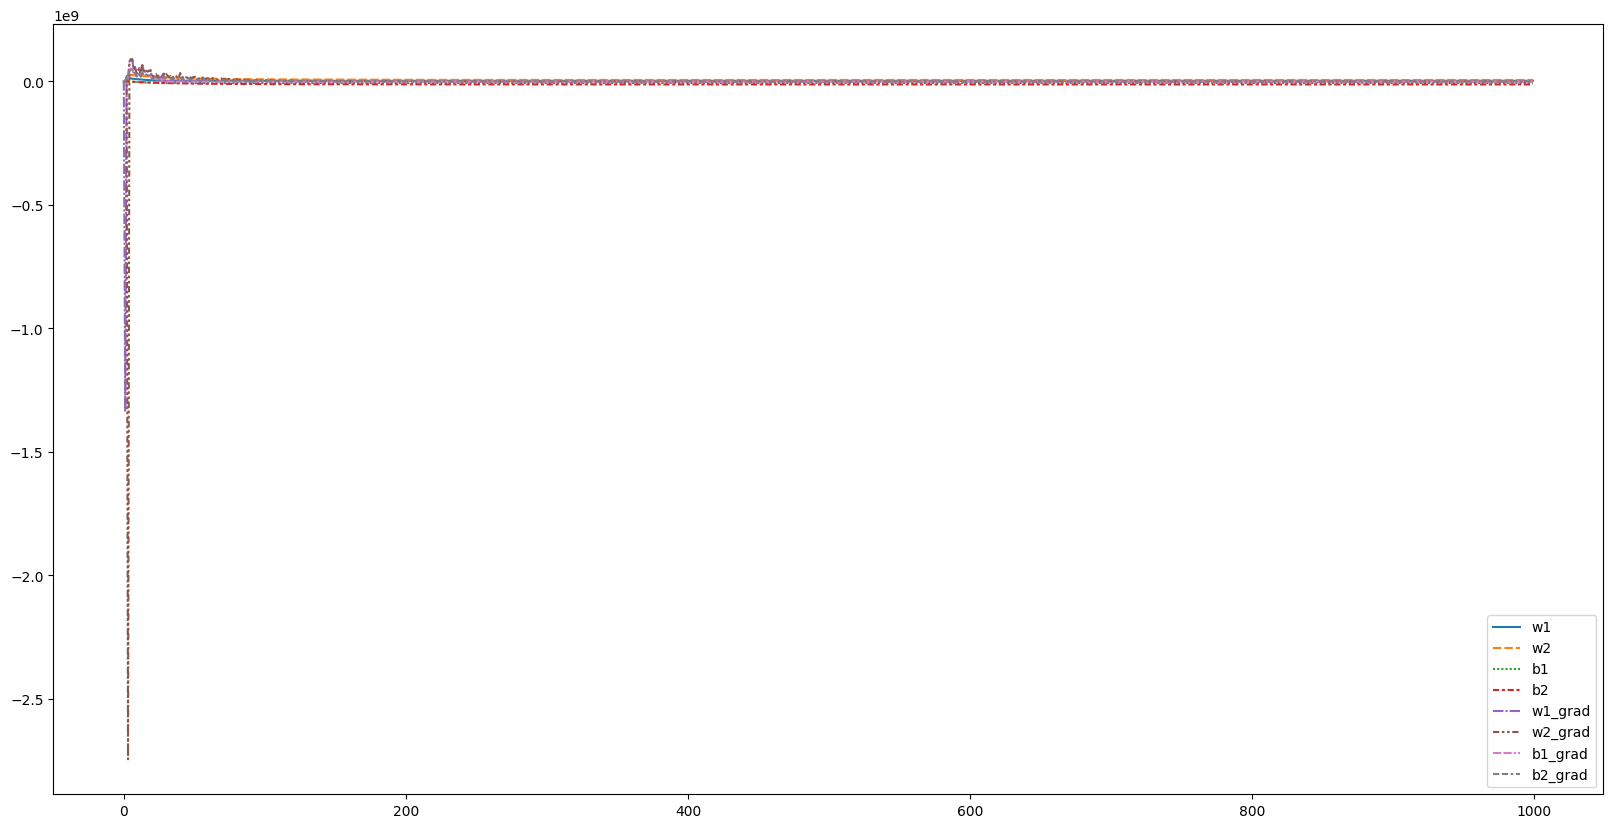

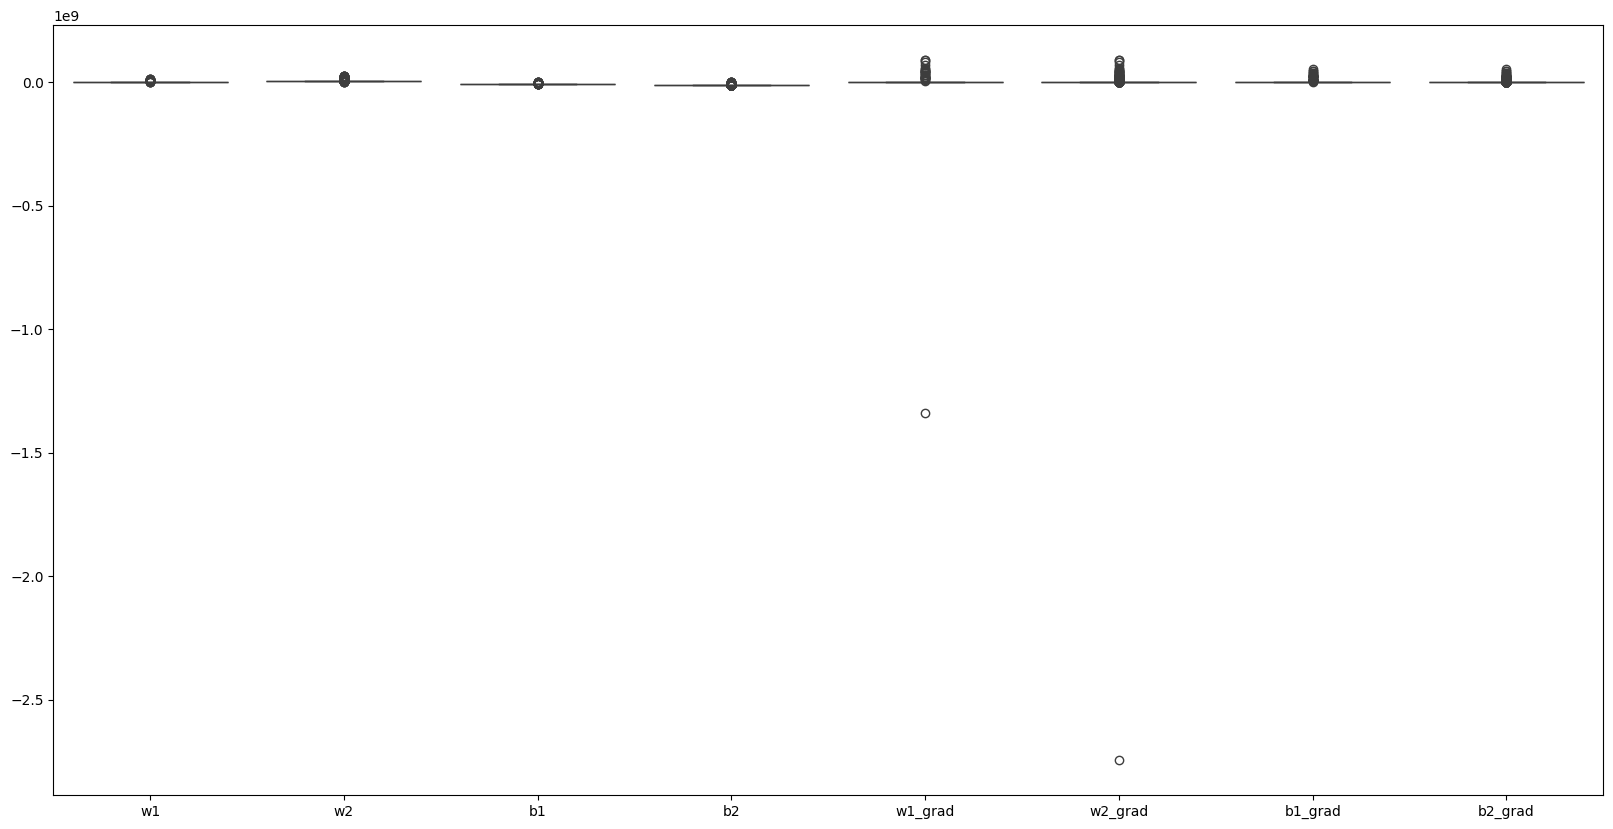

In [26]:
import seaborn as sns

df_w = pd.DataFrame(df_c["net.0.0.weight"].apply(lambda x: [x[0][0], x[1][0]]).tolist(), columns=["w1", "w2"])
df_w_g = pd.DataFrame(df_c["net.0.0.weight.grad"].apply(lambda x: [x[0][0], x[1][0]]).tolist(), columns=["w1_grad", "w2_grad"])
df_b = pd.DataFrame(df_c["net.0.0.bias"].tolist(), columns=["b1", "b2"])
df_b_g = pd.DataFrame(df_c["net.0.0.bias.grad"].tolist(), columns=["b1_grad", "b2_grad"])
df = pd.concat([df_w, df_b, df_w_g, df_b_g], axis=1)
figsize = (20, 10)
plt.figure(figsize=figsize)
sns.barplot(data=df)
plt.figure(figsize=figsize)
sns.lineplot(data=df)
plt.figure(figsize=figsize)
sns.boxplot(data=df)
df.describe()

[-2.0, 0.0, 2.0, 1.2, -1.2]

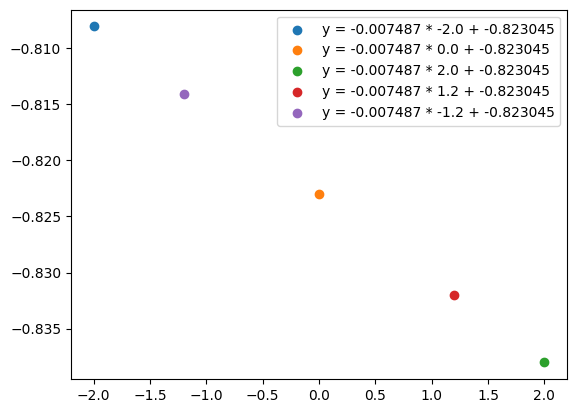

In [20]:
w1_v = -0.007487
b1_v = -0.823045
for x in ds:
    plt.scatter(x, x * w1_v + b1_v, label=f"y = {w1_v} * {x} + {b1_v}")
plt.legend()
ds

In [361]:
m4.net

ModuleList(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=2, bias=True)
    (1): ReLU()
  )
)

In [336]:
import plotly.graph_objects as go

net = m4.net
w1 = net[0][0].weight.data
b1 = net[0][0].bias
r1 = net[0][1]
# w2 = net[1][0].weight
# b2 = net[1][0].bias
ds_t = torch.tensor(ds).unsqueeze(-1)
res1 = (ds_t @ w1.T + b1).detach()
#res2 = (r1(res1) @ w2.T + b2).detach()

fig = go.Figure()
def scatter3d(x, y=None, z=None, name="", color=""):
    if y is None:
        y = torch.tensor([0]).tile(x.shape)
    if z is None:
        z = torch.tensor([0]).tile(x.shape)
    fig.add_trace(go.Scatter3d(
        x=x.detach().numpy().tolist(),
        y=y.detach().numpy().tolist(),
        z=z.detach().numpy().tolist(),
        marker=dict(size=5,color=color),
        name=name
    ))

scatter3d(res1[:, 0], res1[:, 1], res1[:, 2], "X @ W1.T + B1", "green")
scatter3d(r1(res1)[:, 0], r1(res1)[:, 1], r1(res1)[:, 2], "ReLU(X @ W1.T + B1)", "orange")
#scatter3d(res2.flatten(), name="ReLU(X @ W1.T + B1) @ W2.T + B2", color="blue")
# print(w2)
# print(b2)
xx = torch.tensor([-5, 5])
scatter3d(xx * w1.T[:, 0] + b1[0], xx * w1.T[:, 1] + b1[1], xx * w1.T[:, 2] + b1[2], "[-5, 5] @ W1.T + B1", "red")
scatter3d(r1(xx * w1.T[:, 0] + b1[0]), r1(xx * w1.T[:, 1] + b1[1]), r1(xx * w1.T[:, 2] + b1[2]), "ReLU([-5, 5] @ W1.T + B1)", "purple")

fig.update_layout(
    autosize=False,
    width=1200,
    height=800,
)

Parameter containing:
tensor([[-0.0198,  1.8317,  1.5926]], requires_grad=True)
Parameter containing:
tensor([-0.2120], requires_grad=True)


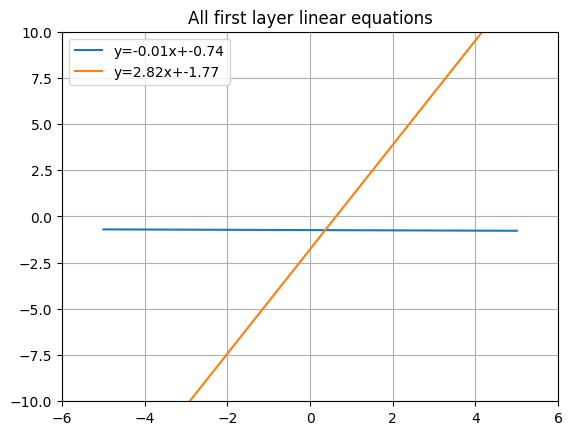

In [362]:
xx_t = xx.unsqueeze(-1).float()
rr = xx_t @ w1.T + b1
plt.plot(xx, rr[:, 0].detach().numpy())
plt.plot(xx, rr[:, 1].detach().numpy())
#plt.plot(xx, rr[:, 2].detach().numpy())
w1_l = [round(x, 2) for x in w1.T[0].tolist()]
b1_l = [round(x, 2) for x in b1.tolist()]
y1 = f"{w1_l[0]}x+{b1_l[0]}"
y2 = f"{w1_l[1]}x+{b1_l[1]}"
#y3 = f"{w1_l[2]}x+{b1_l[2]}"
plt.legend([f"y={y1}", f"y={y2}", ])#f"y={y3}"])

def prepare_grid(title):
    plt.title(title)
    plt.xlim(-6, 6)
    plt.ylim(-10, 10)
    plt.grid(True)

prepare_grid("All first layer linear equations")

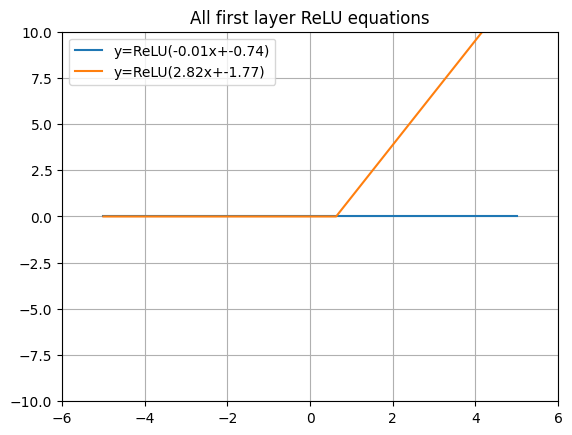

In [363]:
rrr = r1(rr)
# Resolve all y equations
cross_0 = torch.tensor([-0.62, 0.63, -0.74])
xxx = torch.stack([xx[0].tile(3), cross_0, xx[1].tile(3)])

rrr = torch.stack([rrr[0], torch.zeros(3), rrr[1]])

plt.plot(xxx[:, 0], rrr[:, 0].detach().numpy())
plt.plot(xxx[:, 1], rrr[:, 1].detach().numpy())
# plt.plot(xxx[:, 2], rrr[:, 2].detach().numpy())
plt.legend([f"y=ReLU({y1})", f"y=ReLU({y2})", ])#f"y=ReLU({y3})"])

prepare_grid("All first layer ReLU equations")

In [176]:
print(ds_t)
print(ds_t @ w1.T)


tensor([[-2.0000],
        [ 0.0000],
        [ 2.0000],
        [ 1.2000],
        [-1.2000]])
tensor([[ 0.0150, -3.1053,  3.2853],
        [-0.0000,  0.0000, -0.0000],
        [-0.0150,  3.1053, -3.2853],
        [-0.0090,  1.8632, -1.9712],
        [ 0.0090, -1.8632,  1.9712]])


Epoch: 0 ; Loss 0.1010
Epoch: 5000 ; Loss 0.0031


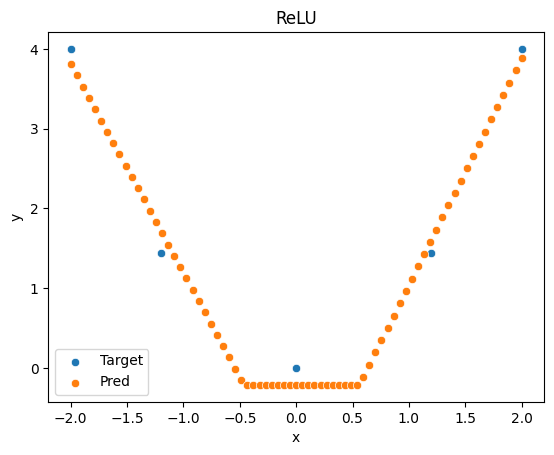

Epoch: 0 ; Loss 0.0893
Epoch: 5000 ; Loss 0.0908


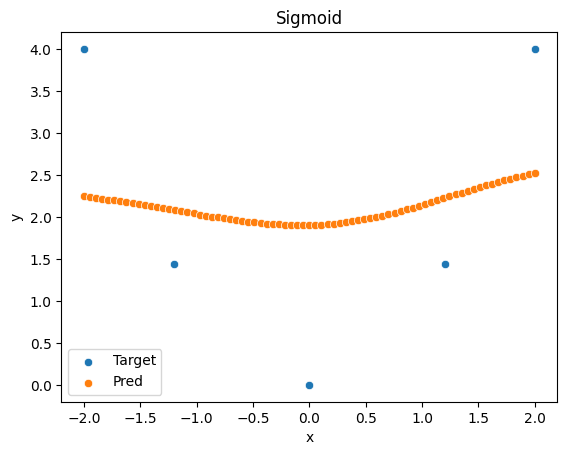

Epoch: 0 ; Loss 0.1352
Epoch: 5000 ; Loss 0.0215


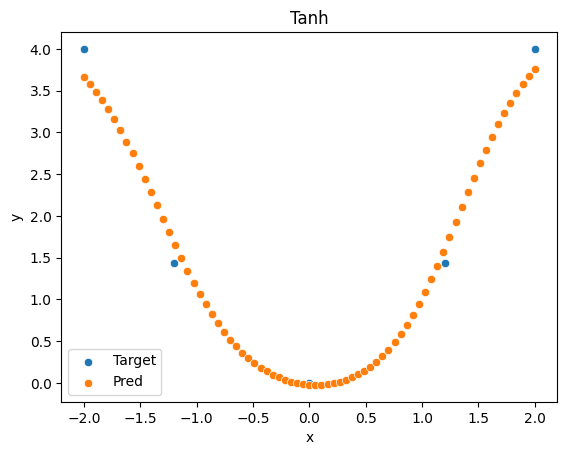

Epoch: 0 ; Loss 0.0862
Epoch: 5000 ; Loss 0.0019


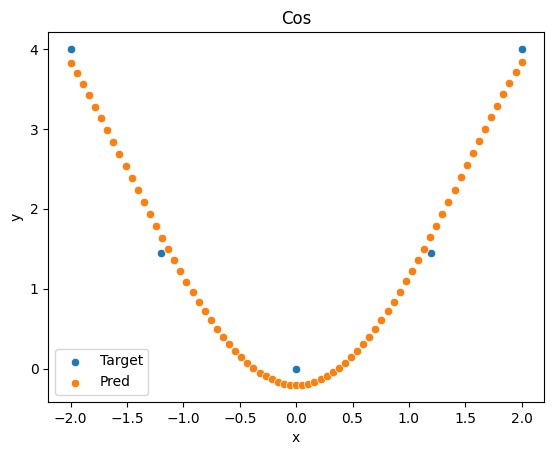

Epoch: 0 ; Loss 0.1397
Epoch: 5000 ; Loss 0.0021


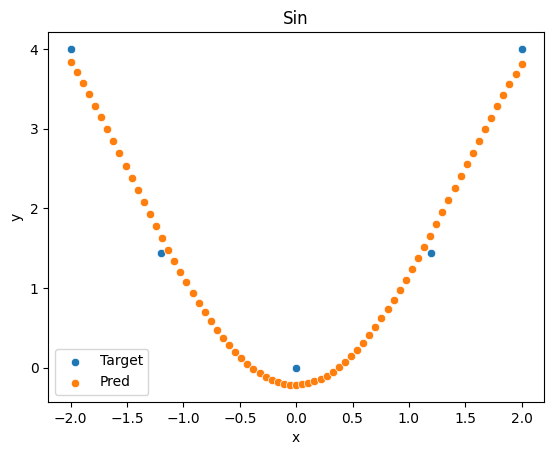

Epoch: 0 ; Loss 0.1615
Epoch: 5000 ; Loss 0.0936


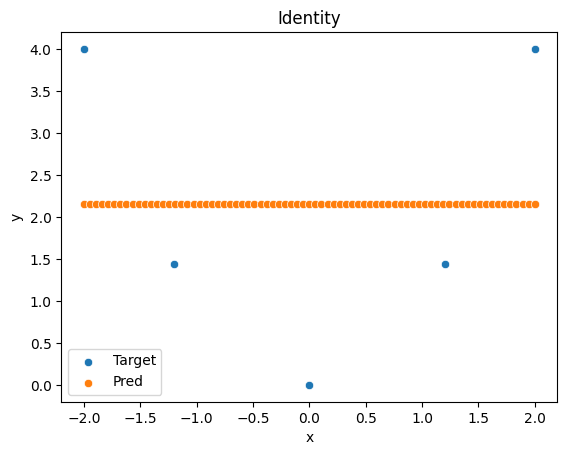

/home/alan/.cache/pypoetry/virtualenvs/ai-4-alan-3pcBkBoY-py3.11/lib/python3.11/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: 0 ; Loss 0.0937
Epoch: 5000 ; Loss 0.0749


/home/alan/.cache/pypoetry/virtualenvs/ai-4-alan-3pcBkBoY-py3.11/lib/python3.11/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


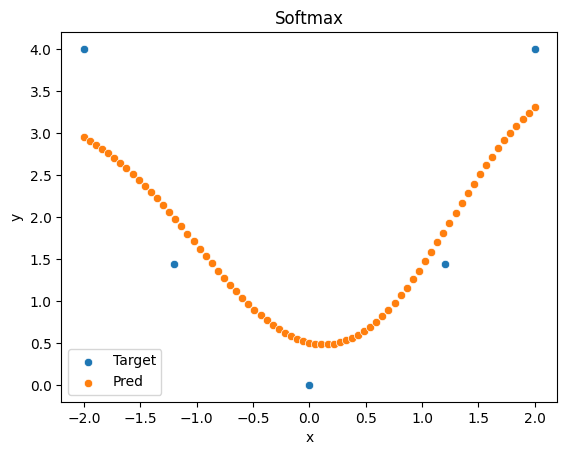

Epoch: 0 ; Loss 0.0873
Epoch: 5000 ; Loss 0.0019


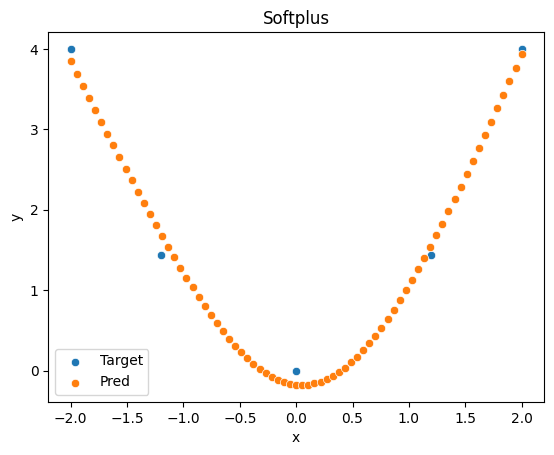

Epoch: 0 ; Loss 0.1319
Epoch: 5000 ; Loss 0.0024


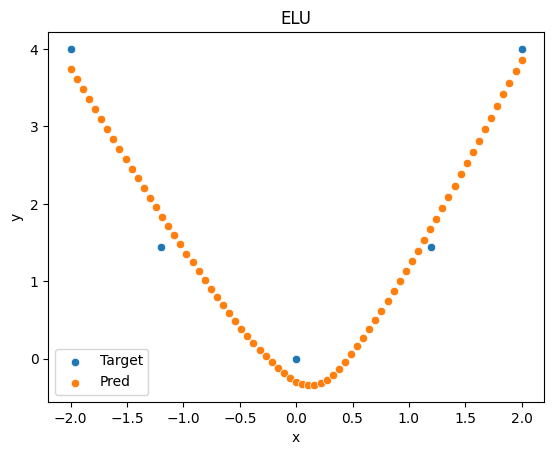

Epoch: 0 ; Loss 0.1015
Epoch: 5000 ; Loss 0.0031


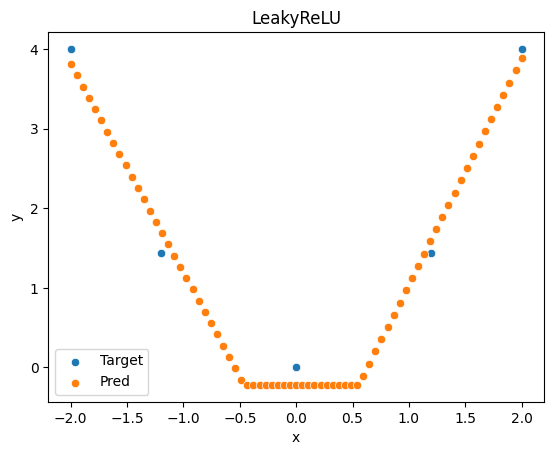

Epoch: 0 ; Loss 0.1221
Epoch: 5000 ; Loss 0.0751


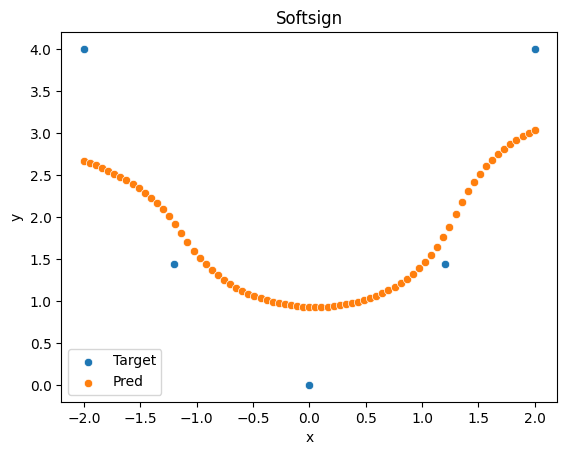

/home/alan/.cache/pypoetry/virtualenvs/ai-4-alan-3pcBkBoY-py3.11/lib/python3.11/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: 0 ; Loss 0.2914
Epoch: 5000 ; Loss 0.0033


/home/alan/.cache/pypoetry/virtualenvs/ai-4-alan-3pcBkBoY-py3.11/lib/python3.11/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


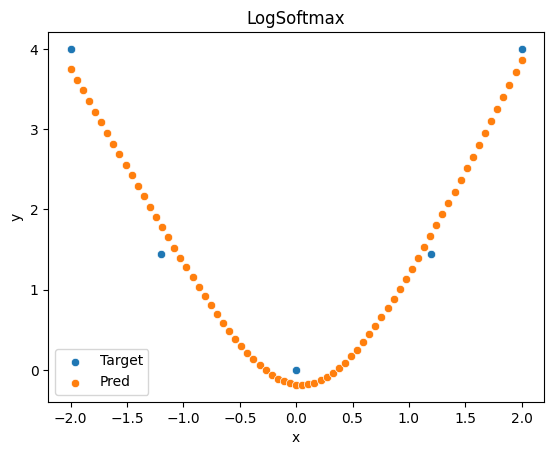

Epoch: 0 ; Loss 0.0596
Epoch: 5000 ; Loss 0.0000


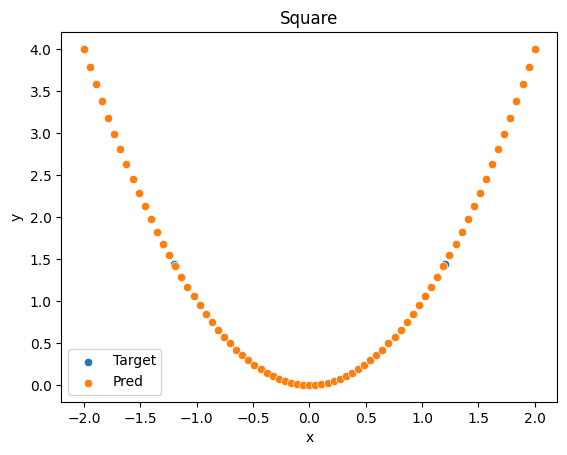

Epoch: 0 ; Loss 0.0638
Epoch: 5000 ; Loss 0.0042


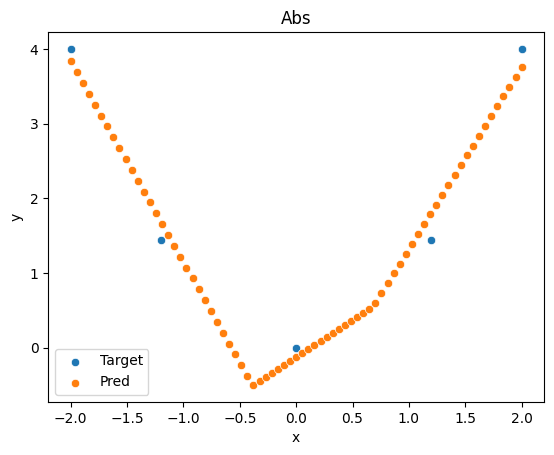

In [29]:
class Cos(nn.Module):
    def forward(self, x):
        return x.cos()
    
class Sin(nn.Module):
    def forward(self, x):
        return x.sin()
    
class Square(nn.Module):
    def forward(self, x):
        return x ** 2
    
class Abs(nn.Module):
    def forward(self, x):
        return x.abs()

activations = [nn.ReLU, nn.Sigmoid, nn.Tanh, Cos, Sin, nn.Identity, nn.Softmax, nn.Softplus, nn.ELU, nn.LeakyReLU, nn.Softsign, nn.LogSoftmax, Square, Abs]
for a in activations:
    m5 = MLP(1, [3, 1], activation=a)
    run(m5, 10000, 32, 1e-3, sampler=sampler, precision=ds, target_fn=lambda x: x**2, red=lambda x: sum(x) / len(x), val_precision=torch.linspace(-2, 2, 75), show_weigths=False, loss_print_ratio=0.5)
    plt.title(a.__name__)
    plt.show()